1. 데이터 불러오기/변환
2. Text자료 가공
  1. 부정리뷰 추이
  2. Wordcloud
  3. 주요단어(top 30)
  4. 연관단어(keyword 기준)
  5. 특이리뷰(요청한 키워드가 포함된 내용)
3. 이메일 양식 작성


In [1]:
# DB접속
import pymysql
import pandas as pd
import numpy as np

# from konlpy.tag import Okt
# okt = Okt("C:/Program Files/Java/jdk-12.0.1/bin/server/jvm.dll")

# 한글정제 KoNLPy
from ckonlpy.tag import Twitter
twitter = Twitter()

# 그래프
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
path = 'C:/windows/Fonts/malgun.ttf'                           # 폰트:맑은고딕
font_name = fm.FontProperties(fname=path, size=24).get_name()  
plt.rc('font', family=font_name)

# 분석1 : Trend 탐식 시, 이상치 확인
from sklearn.neighbors import LocalOutlierFactor

# 분석2 : wordcloud 준비
from wordcloud import WordCloud

# 분석3 : text rank 도출
import itertools
import nltk

# 시간기록
from datetime import datetime, timedelta
import time 

# 내용공유(e-mailm gmail) 
import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime.base import MIMEBase
from email.mime.text import MIMEText
from email.mime.image import MIMEImage
from email import encoders
from email.header import Header
from jinja2 import Template

import warnings
warnings.filterwarnings("ignore")

C:\ProgramData\Anaconda3\lib\site-packages\konlpy\tag\_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


### I.데이터 불러오기

In [2]:
# 제품군 정보
df_product = pd.read_excel('./PRODUCT.xlsx','Sheet1')
df_product['PRODUCT_CODE'] = df_product['PRODUCT_CODE'].astype(object)

In [27]:
#########
# rawdata 불러오기
###

# DB연결
conn = pymysql.connect(host = '**.***.*.*', user ='__USER_ID__', password = "__PASSWORD__", database='__DATABASE__')

# cursor 설정
cursor = conn.cursor(pymysql.cursors.DictCursor)

# 쿼리실행
sql= '''select PRODUCT_CODE
        , (SELECT code_nm FROM JT_CODE B WHERE A.PRODUCT_CODE = B.CODE AND B.CODE_GRP_ID = 'PRODUCT')"상품명"
        , A.GRADE as "구매자평점" 
        , A.CONTENTS as 리뷰상세내용
        , (STR_TO_DATE(A.WRITE_DT, '%Y%m%d'))  as 리뷰등록일 
        , DATE_FORMAT(substr(A.WRITE_DT, 1,8), '%Y-%U') as reg_wk 
        , (SELECT CODE_NM FROM JT_CODE B WHERE A.COMPANY_CODE = B.CODE AND B.CODE_GRP_ID = 'DEALER_ID') as 수집체널 
        FROM MAEIL_REVIEW A
        where GRADE in (1,2)
        and PRODUCT_CODE in (204412,106213,910609,106526,910592,910585,106054,105781,106035,106055,106138,106462,106461,106013,106014,106011,105875,105873,106348,106349,106558,106093,106018,910577,910586,105046,910580,106583,105938)
        and DATE_FORMAT(substr(A.WRITE_DT, 1,8), '%Y/%m/%d') between DATE_ADD(curdate(),INTERVAL - 180 DAY) and DATE_ADD(curdate(),INTERVAL -1 DAY)
        group by A.COMPANY_CODE, A.WRITER, A.CONTENTS, A.WRITE_DT, A.GRADE, A.PRODUCT_CODE
        order by A.WRITE_DT
        '''
cursor.execute(sql)
dataset = cursor.fetchall()
dataset = pd.DataFrame(dataset)
dataset['리뷰등록일'] = pd.to_datetime(dataset['리뷰등록일'])

In [29]:
# 쿼리실행
sql= '''select PRODUCT_CODE
        , (SELECT code_nm FROM JT_CODE B WHERE A.PRODUCT_CODE = B.CODE AND B.CODE_GRP_ID = 'PRODUCT')"상품명"
        , A.GRADE as "구매자평점" 
        , A.CONTENTS as 리뷰상세내용
        , (STR_TO_DATE(A.WRITE_DT, '%Y%m%d'))  as 리뷰등록일 
        , DATE_FORMAT(substr(A.WRITE_DT, 1,8), '%Y-%U') as reg_wk 
        , (SELECT CODE_NM FROM JT_CODE B WHERE A.COMPANY_CODE = B.CODE AND B.CODE_GRP_ID = 'DEALER_ID') as 수집체널 
        FROM MAEIL_REVIEW A
        where GRADE in (1,2)
        and PRODUCT_CODE in (204412,106213,910609,106526,910592,910585,106054,105781,106035,106055,106138,106462,106461,106013,106014,106011,105875,105873,106348,106349,106558,106093,106018,910577,910586,105046,910580,106583,105938)
        and DATE_FORMAT(substr(A.WRITE_DT, 1,8), '%Y/%m/%d') between DATE_ADD(curdate(),INTERVAL - 8 DAY) and DATE_ADD(curdate(),INTERVAL -1 DAY)
        group by A.COMPANY_CODE, A.WRITER, A.CONTENTS, A.WRITE_DT, A.GRADE, A.PRODUCT_CODE
        order by A.WRITE_DT
        '''
cursor.execute(sql)
dataset3 = cursor.fetchall()
dataset3 = pd.DataFrame(dataset3)
dataset3['리뷰등록일'] = pd.to_datetime(dataset3['리뷰등록일'])

In [71]:
# 쿼리실행
sql= '''select PRODUCT_CODE
        , (SELECT code_nm FROM JT_CODE B WHERE A.PRODUCT_CODE = B.CODE AND B.CODE_GRP_ID = 'PRODUCT')"상품명"
        , A.GRADE as "구매자평점" 
        , A.CONTENTS as 리뷰상세내용
        , (STR_TO_DATE(A.WRITE_DT, '%Y%m%d'))  as 리뷰등록일 
        , DATE_FORMAT(substr(A.WRITE_DT, 1,8), '%Y-%U') as reg_wk 
        , (SELECT CODE_NM FROM JT_CODE B WHERE A.COMPANY_CODE = B.CODE AND B.CODE_GRP_ID = 'DEALER_ID') as 수집체널 
        FROM MAEIL_REVIEW A
        where GRADE in (1,2,3,4,5)
        and PRODUCT_CODE in (204412,106213,910609,106526,910592,910585,106054,105781,106035,106055,106138,106462,106461,106013,106014,106011,105875,105873,106348,106349,106558,106093,106018,910577,910586,105046,910580,106583,105938)
        and DATE_FORMAT(substr(A.WRITE_DT, 1,8), '%Y/%m/%d') between DATE_ADD(curdate(),INTERVAL - 180 DAY) and DATE_ADD(curdate(),INTERVAL -1 DAY)
        group by A.COMPANY_CODE, A.WRITER, A.CONTENTS, A.WRITE_DT, A.GRADE, A.PRODUCT_CODE
        order by A.WRITE_DT
        '''
cursor.execute(sql)
dataset4 = cursor.fetchall()
dataset4 = pd.DataFrame(dataset4)
dataset4['리뷰등록일'] = pd.to_datetime(dataset4['리뷰등록일'])

In [65]:
# 쿼리실행
sql= '''select (SELECT code_nm FROM JT_CODE B WHERE left(A.PRODUCT_CODE,6) =B.CODE AND B.CODE_GRP_ID = 'PRODUCT') "상품명"
        , (SELECT left(code_nm,1) FROM JT_CODE B WHERE A.CS_GUBUN = B.CODE AND B.CODE_GRP_ID = 'CS_GUBUN') "CS유형"
        , (SELECT code_nm FROM JT_CODE B WHERE A.CS_GUBUN = B.CODE AND B.CODE_GRP_ID = 'CS_GUBUN') "CS유형_상세"
        , (STR_TO_DATE(A.INS_DM, '%Y%m%d')) as 인입일자 
        , CNTS
        , DATE_FORMAT(substr(A.INS_DM, 1,8), '%Y-%U') as reg_wk 
        from MAEIL_CS A
        where PRODUCT_CODE in (204412,106213,910609,106526,910592,910585,106054,105781,106035,106055,106138,106462,106461,106013,106014,106011,105875,105873,106348,106349,106558,106093,106018,910577,910586,105046,910580,106583,105938)
        and DATE_FORMAT(substr(INS_DM, 1,8), '%Y/%m/%d') between DATE_ADD(curdate(),INTERVAL - 180 DAY) and DATE_ADD(curdate(),INTERVAL -1 DAY)
        '''
cursor.execute(sql)
dataset2 = cursor.fetchall()
dataset2 = pd.DataFrame(dataset2)
dataset2['인입일자'] = pd.to_datetime(dataset2['인입일자'])

In [35]:
dataset3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113 entries, 0 to 112
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   PRODUCT_CODE  113 non-null    object        
 1   상품명           113 non-null    object        
 2   구매자평점         113 non-null    object        
 3   리뷰상세내용        113 non-null    object        
 4   리뷰등록일         113 non-null    datetime64[ns]
 5   reg_wk        113 non-null    object        
 6   수집체널          113 non-null    object        
dtypes: datetime64[ns](1), object(6)
memory usage: 6.3+ KB


In [5]:
trend_review2 = pd.pivot_table(dataset2, values='CS유형_상세', index='CS유형',columns=['reg_wk'], aggfunc="count").fillna(0)

In [8]:
# 기준 테이블 작성
df_gubun = pd.DataFrame()
df_gubun['CS유형']      = ['1' ,'2' ,'3' ,'4' ,'5' ,'6' ,'7' ,'8' ,'9' ]
df_gubun['CS유형_내용'] = ['배송누락','배송지연','취소/반품/교환','택배사 파손','제품불량','취소/반품의 취소','제품문의','배송문의','기타']

In [27]:
# trend_review2.index

Index(['1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype='object', name='CS유형')

In [9]:
# trend_review2 = pd.merge(df_gubun, trend_review2, left_on=['CS유형'], right_on=['CS유형'], how='outer')

In [144]:
# dataset['PRODUCT_CODE'] = dataset['PRODUCT_CODE'].astype(int)

In [145]:
# dataset = pd.merge(dataset, df_product, on ='PRODUCT_CODE',  how='left')

In [146]:
# dataset.groupby('PRODUCT_CODE')['상품명'].count()

In [147]:
# dataset.info()

In [148]:
# dataset.reg_wk.unique()[-5:]

In [31]:
###############
# Text 정제
#####

# 사전에 고유 명사 추가
twitter.add_dictionary('셀렉스', 'Noun')
twitter.add_dictionary('무설탕', 'Noun')
twitter.add_dictionary('프로틴', 'Noun')
twitter.add_dictionary('보냉백', 'Noun')
twitter.add_dictionary('라방', 'Noun')
twitter.add_dictionary('재구매', 'Noun')
twitter.add_dictionary('유통기한', 'Noun')
twitter.add_dictionary('사은품', 'Noun')
twitter.add_dictionary('아몬드브리즈', 'Noun')
twitter.add_dictionary('팥빙수', 'Noun')

def tokenize(doc):
    result = ['/'.join(t) for t in twitter.pos(doc, norm=True, stem=True)] # ex '더빙/Norm', '나다/Verb'
    return result 

def listToString(s):  
    str1 = ""  
    for ele in s:  
        str1 += " " + ele.strip()  
    return str1

In [32]:
df_temp = dataset['리뷰상세내용'].replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

# regex to konlpy
token_1 = [tokenize(row) for row in df_temp ]  

data_trim2 = []
for i in range(len(df_temp)):
    t = ' '.join(token_1[i])
    data_trim2.append(t.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]",""))
    
df_temp = pd.DataFrame(data_trim2)
df_temp = df_temp[0].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

dataset['token'] = df_temp

In [33]:
df_temp3 = dataset3['리뷰상세내용'].replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

# regex to konlpy
token_1 = [tokenize(row) for row in df_temp3 ]  

data_trim2 = []
for i in range(len(df_temp3)):
    t = ' '.join(token_1[i])
    data_trim2.append(t.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]",""))
    
df_temp3 = pd.DataFrame(data_trim2)
df_temp3 = df_temp3[0].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

dataset3['token'] = df_temp3

In [76]:
df_temp4 = dataset4['리뷰상세내용'].replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

# regex to konlpy
token_1 = [tokenize(row) for row in df_temp4 ]  

data_trim2 = []
for i in range(len(df_temp4)):
    t = ' '.join(token_1[i])
    data_trim2.append(t.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]",""))
    
df_temp4 = pd.DataFrame(data_trim2)
df_temp4 = df_temp4[0].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

dataset4['token'] = df_temp4

In [8]:
len(dataset)

113

### III.데이터 리포팅

#### 1.제품 현황

In [34]:
df_temp2 = pd.DataFrame(dataset2.groupby(['상품명'], as_index =False)['CS유형'].count())
df_temp2.rename(columns = { 'CS유형' : 'CS문의 수(A)' }, inplace = True)

df_temp1 = pd.DataFrame(dataset.groupby(['상품명'], as_index =False)['PRODUCT_CODE'].count())
df_temp1.rename(columns = { 'PRODUCT_CODE' : '부정리뷰 수(B)' }, inplace = True)

product_list = df_temp2.merge(df_temp1, how='left', on='상품명').fillna(0)
product_list['%(B/A)'] = round(product_list['부정리뷰 수(B)']/product_list['CS문의 수(A)']*100,1)

In [35]:
product_list

,상품명,CS문의 수(A),부정리뷰 수(B),%(B/A)
0,멸균 셀렉스 음료 [ 로우슈거 ] [ 125ML ],104,9.0,8.7
1,멸균 셀렉스 음료 [ 오리지널 ] [ 125ML ],230,10.0,4.3
2,밀크세라마이드 체험키트 [ 7포 ] [ NEW ],29,1.0,3.4
3,셀렉스 [ 선물세트 ] [ 밀크세라마이드 ],21,3.0,14.3
4,셀렉스 [ 세트 ] [ 코어프로틴 ] [ 캔&스틱 ],12,0.0,0.0
5,셀렉스 밀크세라마이드 [ 요거트맛 ] [ 2.7G X 28 ],174,16.0,9.2
6,셀렉스 밀크세라마이드 마스크 [ 25G X 5매입 ],11,13.0,118.2
7,셀렉스 스포츠 [ 드링크 ] [ NEW ] [ 복숭아 ] [ 330ml ],40,6.0,15.0
8,셀렉스 스포츠 [ 드링크 ] [ NEW ] [ 초콜릿 ] [ 330ml ],47,10.0,21.3
9,셀렉스 스포츠 [ 드링크 ] [ 초콜릿 ] [ 330ml ],72,16.0,22.2


In [14]:
print('제품 그룹 : 두유')
print('제품 SKU 겟수 : {}'.format(len(product_list)))

제품 그룹 : 두유
제품 SKU 겟수 : 10


In [24]:
dataset3

,PRODUCT_CODE,상품명,구매자평점,리뷰상세내용,리뷰등록일,reg_wk,수집체널,token
0,104154,멸균 매일두유 [ 99.89 ] [ 190ml ],2,"귀사의 무설탕 매일두유를 여러차례 주문구매하여 잘 먹고있는 소비자입니다.\n다만, ...",2021-01-25,2021-04,3 네이버,귀사 의 무설탕 매일 두유 를 여러 차례 주 문구 매하 여 자다 먹다 소비자 이다 ...
1,104154,멸균 매일두유 [ 99.89 ] [ 190ml ],2,"아침에 한잔 마셔도 좋고, 빵과 함께 먹어도 좋은 무설탕 두유를 몇차례 주문 구매하...",2021-01-25,2021-04,3 네이버,아침 에 한잔 마시다 좋다 빵 과 함께 먹다 어도 좋다 무설탕 두유 를 몇 차례 ...
2,104154,멸균 매일두유 [ 99.89 ] [ 190ml ],2,생각보다 맛이 별로에요,2021-01-27,2021-04,3 네이버,생각 보다 맛 이 별로 에요
3,104154,멸균 매일두유 [ 99.89 ] [ 190ml ],2,설탕무첨가 상품이라서 너무 싱겁고 물 마시는거 같아요,2021-01-28,2021-04,3 네이버,설탕 무 첨가 상품 이라서 너무 싱겁다 물 마시다 같다
4,105644,멸균 매일두유 [ 검은콩 ] [ 190ml ],1,"주문할 때는 구매확정 1000포인트라 구매했는데, 구매확정할 때 되니까 이벤트 종료...",2021-01-28,2021-04,3 네이버,주문 하다 때 는 구매 확정 포인트 라 구매 하다 구매 확정 하다 때 되다 니까...
...,...,...,...,...,...,...,...,...
108,105644,멸균 매일두유 [ 검은콩 ] [ 190ml ],1,맛 없어요... 별로 안사고 싶어요,2021-07-16,2021-28,3 네이버,맛 없다 어요 별로 안 사고 싶다 어요
109,105644,멸균 매일두유 [ 검은콩 ] [ 190ml ],2,맛이 흐려서 그런가 별로였어요.,2021-07-18,2021-29,3 네이버,맛 이 흐리다 그 런가 별로 이다 어요
110,104154,멸균 매일두유 [ 99.89 ] [ 190ml ],2,정말 안 달아서.... 건강한 맛 추구하는 사람들에게 추천합니다..,2021-07-19,2021-29,3 네이버,정말 안 달다 건강 한 맛 추구 하다 사람 들다 에게 추천 하다
111,105644,멸균 매일두유 [ 검은콩 ] [ 190ml ],1,맛도 없고\n다음에는 구입 안함,2021-07-19,2021-29,3 네이버,맛 도 없다 다음 에는 구입 안함


#### 1.부정리뷰 추이 + word cloud

이슈사항
  + [ ] 부정리뷰 범위 : 1,2 vs 1,2,3
  + [ ] Outlier 모델 : LOF(LocalOutlierFactor)

In [36]:
trend_review1 = pd.DataFrame(dataset.groupby('reg_wk')['리뷰상세내용'].count().reset_index())
trend_review3 = pd.DataFrame(dataset3.groupby('리뷰등록일')['리뷰상세내용'].count().reset_index())

# dist_review1  = pd.DataFrame(dataset.groupby('구매자평점')['리뷰상세내용'].count().reset_index())

In [37]:
# fit the model for outlier detection (default)
clf = LocalOutlierFactor(n_neighbors=20, contamination=0.1)

test = np.array(trend_review1.리뷰상세내용)
trend_review1['outliear'] = clf.fit_predict(test.reshape(-1,1))

In [38]:
stopword = ['먹다', '하다', '좋다'  , '예요', '이에요', '있다', '맛있다', '같다', '없다', '보통', '최고', '주문', '보다', '매일',
         '구매', '에서', '먹이다', '않다', '자다'  , '들다', '사다'  , '되다', '으로', 'ㅠㅠ', 'ㅜㅜ', '말다', '이다', '받다',
         '아직', '이다', '보이다', '이나', '오다'  , '이라', '우유'  , '배달', '배송', '가정', '제품', '신청', '문의', '되어다',
         '넘다', 'ㅋㅋ', 'ㅋㅋㅋ', 'ㅎㅎ', '진짜'  , '너무', '이', '는', '요', '은', '에', '기', '다', '도', '원', '구', '개', '랑','가',
         '도', '임시', '이미지', '확인', '후', '을', '안' ,'되다', '하', '심', '고객', '님', '어요', '좀', '것', '니', '어보', '타',
         '생각', '지만', '잘', '제', '니다', '네', '해', '그래도', '엄청', '하고', '번', '그', '나다', '시', '다가', '한', '해서', '로',
         '더', '못', '에는', '던데', '일단', '나요', '아하', '이적','이고', '려고', '이라고', '고', '어서','를', '그냥', '만', '짧다',
         '유통기한', '인데', '박스', '까지', '일', '월', '두', '팩','어요', '요','다', '한', '있다', '라', '나', '게', '거', '데',
         '더니','달', '보', '이번', '이네', '내주', '하나', '수', '저', '이렇다', '이렇게', 'ㅠ'
         ]

In [39]:
text = df_temp.to_list()
text_all = listToString(text)
    
# worldcloud 생성
wc = WordCloud(font_path= path, stopwords = stopword, width = 900, height = 600, background_color="white", repeat=True)
wc.generate(text_all)


text = df_temp3.to_list()
text_all = listToString(text)
    
# worldcloud 생성
wc3 = WordCloud(font_path= path, stopwords = stopword, width = 900, height = 600, background_color="white", repeat=True)
wc3.generate(text_all)


In [40]:
trend_review2

reg_wk,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10,2021-11,2021-12,2021-13,...,2021-20,2021-21,2021-22,2021-23,2021-24,2021-25,2021-26,2021-27,2021-28,2021-29
CS유형,,,,,,,,,,,,,,,,,,,,,
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,2.0,0.0,...,1.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,7.0,5.0,2.0,6.0,7.0,3.0,4.0,6.0,3.0,5.0,...,3.0,4.0,13.0,10.0,12.0,5.0,6.0,9.0,7.0,6.0
4,0.0,0.0,0.0,1.0,3.0,2.0,3.0,2.0,4.0,3.0,...,3.0,6.0,8.0,11.0,45.0,43.0,10.0,9.0,43.0,17.0
5,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,...,7.0,2.0,2.0,8.0,2.0,1.0,1.0,0.0,2.0,1.0
6,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,3.0,0.0,1.0,0.0,1.0
7,15.0,13.0,2.0,12.0,29.0,8.0,9.0,16.0,11.0,13.0,...,8.0,27.0,19.0,20.0,21.0,18.0,22.0,29.0,18.0,23.0
8,21.0,24.0,25.0,66.0,22.0,5.0,12.0,13.0,27.0,8.0,...,10.0,29.0,30.0,17.0,23.0,14.0,7.0,23.0,20.0,9.0
9,20.0,10.0,4.0,3.0,8.0,1.0,1.0,3.0,9.0,7.0,...,10.0,24.0,27.0,22.0,40.0,11.0,18.0,15.0,8.0,10.0


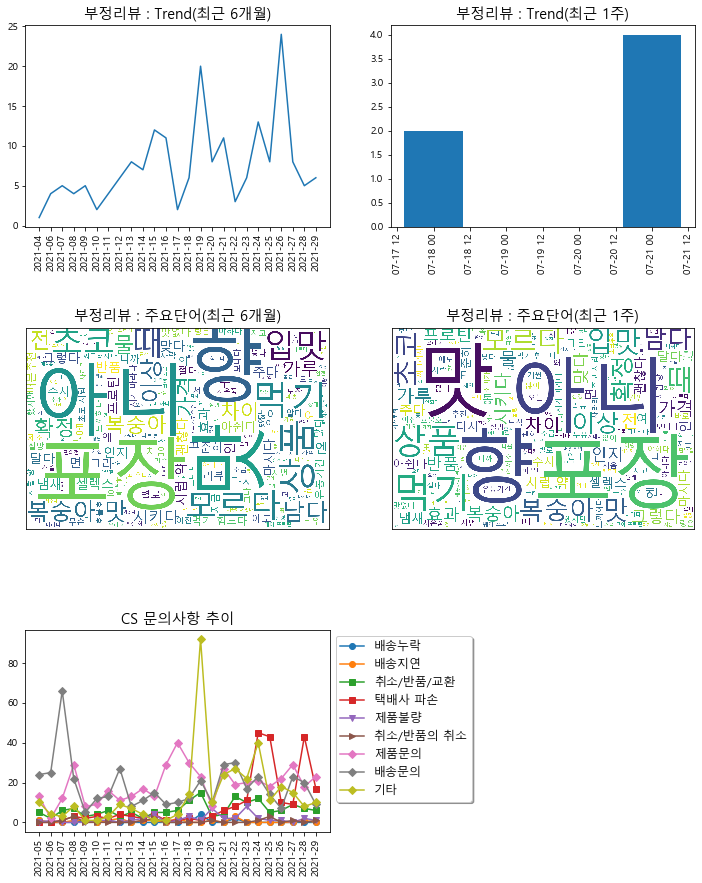

In [41]:
date2 = datetime.today().strftime('%Y%m%d')
image_name = date2[2:] +'_cs_Trend_graph.png'

plt.figure(figsize=(12, 14))

plt.subplot(3,2,1)
plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.5)
plt.plot(trend_review1.reg_wk, trend_review1.리뷰상세내용)
plt.xticks(rotation=90)
plt.title('부정리뷰 : Trend(최근 6개월)',fontsize='x-large')

plt.subplot(3,2,2)
plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.5)
plt.bar(trend_review3.리뷰등록일, trend_review3.리뷰상세내용)
plt.xticks(rotation=90)
plt.title('부정리뷰 : Trend(최근 1주)',fontsize='x-large')

plt.subplot(3,2,3)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(wc, cmap=plt.cm.binary)
plt.title('부정리뷰 : 주요단어(최근 6개월)',fontsize='x-large')

plt.subplot(3,2,4)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(wc3, cmap=plt.cm.binary)
plt.title('부정리뷰 : 주요단어(최근 1주)',fontsize='x-large')

plt.subplot(3,2,5)
plt.plot(trend_review2.iloc[[0]].T[1:],  marker="o", label='배송누락')
plt.plot(trend_review2.iloc[[1]].T[1:],  marker="o", label='배송지연')
plt.plot(trend_review2.iloc[[2]].T[1:],  marker="s", label='취소/반품/교환')
plt.plot(trend_review2.iloc[[3]].T[1:],  marker="s", label='택배사 파손')
plt.plot(trend_review2.iloc[[4]].T[1:],  marker="v", label='제품불량')
plt.plot(trend_review2.iloc[[5]].T[1:],  marker=">", label='취소/반품의 취소')
plt.plot(trend_review2.iloc[[6]].T[1:],  marker="D", label='제품문의')
plt.plot(trend_review2.iloc[[7]].T[1:],  marker="D", label='배송문의')
plt.plot(trend_review2.iloc[[8]].T[1:],  marker="D", label='기타')
lgd = plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fancybox=True, shadow=True, ncol=1,fontsize='large')
plt.xticks(rotation=90)
plt.title('CS 문의사항 추이',fontsize='x-large')

plt.savefig(image_name, bbox_extra_artists=(lgd,), bbox_inches='tight', dpi=70)

#### 3.주요단어(top 30) 

이슈사항
  + [ ] filtering 설정

In [42]:
list4 = list(itertools.chain(*token_1))
list5 = [item.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") for item in list4]

ko = nltk.Text(list5)

In [43]:
data = ko.vocab().items()
df_1 = pd.DataFrame.from_dict(data)
df_1.rename(columns = { 1 : 'count' }, inplace = True)
df_1 = df_1.sort_values('count', ascending=False)

In [44]:
data = ko.vocab().items()
df_1 = pd.DataFrame.from_dict(data)
df_1.rename(columns = { 1 : 'count' }, inplace = True)
df_1 = df_1.sort_values('count', ascending=False)

df_1['속성'] =df_1[0].str.split('/').str[1]
df_1['내용'] =df_1[0].str.split('/').str[0]

# stopword 내용 삭제
df_1 = df_1[~df_1.내용.isin(stopword)]

In [45]:
# 일부 속성 삭제
df_1 = df_1[(df_1['속성']!=  'Punctuation')]
df_1 = df_1[(df_1['속성']!=  'Josa')]
df_1 = df_1[(df_1['속성']!=  'Foreign')]
df_1 = df_1[(df_1['속성']!=  'KoreanParticle')]
df_1 = df_1[(df_1['속성']!=  'Number')]

word_Rank = df_1[['속성', '내용', 'count']].head(20)

# & (df_1['속성']!=  'Josa')& (df_1['속성']!=  'Foreign')& (df_1['속성']!=  'KoreanParticle')& (df_1['속성']!=  'Number')  ][['속성', '내용', 1]].head(20)

In [46]:
word_Rank

,속성,내용,count
2,Noun,맛,104
289,Noun,향,27
178,Noun,복숭아,26
7,Noun,먹기,26
162,Adverb,아니,25
381,Noun,포장,20
743,Noun,프로틴,20
508,Noun,초코,20
233,Noun,전,18
351,Noun,상품,18


#### 4.연관단어(keyword 기준)
이슈사항
  + [ ] keyword 기준 : top30 vs 별도기준
  + [ ] 모델확인 : Word2Vec vs GloVe  vs FastText

In [111]:
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from gensim.models.word2vec import Word2Vec

pos_lines = df_temp4.to_list()

# 단어 추출하기
stop_words = stopword
tokenizer = RegexpTokenizer("[\w]+")

text = []
for line in pos_lines:
    words = line
    tokens = tokenizer.tokenize(words)
    stopped_tokens = [i for i in list(set(tokens)) if not i in stop_words ]
    stopped_tokens2 = [i for i in stopped_tokens if len(i) > 1]
    text.append(stopped_tokens2)

In [112]:
i = 5
print(dataset['리뷰상세내용'][i])
print(pos_lines[i])
print(text[i])

맛은 요거트 맛이라 괜찮아요
혹시나했지만 효과는 없습니다ㅜㅜ
거부 감 없다 맛 이라 아저씨 하고 자다 먹다 해 요
['아저씨', '거부']


In [113]:
# model1 : word2vec 
model1 = Word2Vec(text, size=100, window=5, min_count=1, workers=10, sg=0)
model1.init_sims(replace = True)

In [114]:
model1.wv.vectors.shape

(8522, 100)

In [151]:
# model1 : 결과
keyword = '맛없다' 
try:
    keyword_top10 = model1.wv.most_similar( keyword, topn = 20)
    word_relation = pd.DataFrame(keyword_top10)
    word_relation.rename(columns = {0 : '연관단어', 1 : 'ratio', }, inplace = True)
except:
    word_relation = ''

word_relation

,연관단어,ratio
0,호불호,0.996943
1,으로는,0.993804
2,거리,0.993674
3,으론,0.993635
4,묽다,0.993176
5,강하다,0.992836
6,콩국,0.992678
7,음료수,0.992501
8,오히려,0.992152
9,인위,0.992150


In [116]:
for i in range(len(keyword_top10)):
    print('# {}'.format(keyword_top10[i][0]) )

# 기도
# 보다는
# 유의
# 인적
# 초코우유
# 비리다
# 섞이다
# 처럼
# 얼음
# 살짝


#### 5.특이리뷰(요청한 키워드가 포함된 내용)

이슈사항
  + [ ] rawdata : 

In [159]:
product1 = '코어프로틴'
keyword = '녹다'


data_by_keyword = dataset[ dataset['상품명'].str.contains(str(product1)) & dataset['token'].str.contains(str(keyword)) ]
data_by_keyword.groupby('상품명')['리뷰상세내용'].count()

상품명
셀렉스 코어프로틴플러스 [ 304g ]    1
코어프로틴 프로 6캔 (304gx6캔)    1
Name: 리뷰상세내용, dtype: int64

In [153]:
data_by_keyword

,PRODUCT_CODE,상품명,구매자평점,리뷰상세내용,리뷰등록일,reg_wk,수집체널,token


In [162]:
product1 = '슬림'
keyword = '안 녹다'

data_by_keyword = dataset4[ dataset4['상품명'].str.contains(str(product1)) & dataset4['token'].str.contains(str(keyword)) ]
# data_by_keyword.groupby('상품명')['리뷰상세내용'].count()
# data_by_keyword

In [163]:
date2 = datetime.today().strftime('%Y%m%d')
excel_name = date2 +'_selec.xlsx'
data_by_keyword.to_excel(excel_name, sheet_name= 'Sheet1' )

In [157]:
data_by_keyword

,PRODUCT_CODE,상품명,구매자평점,리뷰상세내용,리뷰등록일,reg_wk,수집체널,token
979,106018,셀렉스 코어프로틴플러스 [ 304g ],5,작은 분유통 같아서 너무 귀여워요ㅋㅋㅋ\n맛도 괜찮고 잘 녹아서 먹기도 좋네요~~\...,2021-01-30,2021-04,3 네이버,작다 분유 통 같다 너무 귀엽다 ㅋㅋㅋ 맛 도 괜찮다 자다 녹다 먹기 도 좋다 ...
1996,106093,셀렉스 코어프로틴플러스 [ 식이섬유 ] [ 294g ],5,부모님께서 꾸준히 드시고 계시는 제품입니다\n고소하고 예전보다 잘 녹아서 더 좋아진...,2021-02-06,2021-05,26 셀렉스 몰,부모님 께서 꾸준히 들다 계시 는 제품 이다 고소 하고 예전 보다 자다 녹다 더 좋...
2742,106018,셀렉스 코어프로틴플러스 [ 304g ],5,맛도좋고 잘녹아서 먹기 편해요,2021-02-09,2021-06,3 네이버,맛 도 좋다 잘 녹다 먹기 편하다
2770,910577,셀렉스 코어프로틴 플러스 스틱 지관 [ 19g x 14 ],5,비싼 초유단백질은 아니지만 그냥 먹기 좋아요. 물에도 잘 녹고. 저는 우유에 타 먹...,2021-02-09,2021-06,3 네이버,비싸다 초유 단백질 은 아 니지 만 그냥 먹기 좋다 물 에도 자다 녹다 저 는 ...
3182,106018,셀렉스 코어프로틴플러스 [ 304g ],4,맛이 밍밍한걸 빼면..너무달지도않고 물에도 잘녹아서 좋습니다. 낱개포장이아니라서 휴...,2021-02-11,2021-06,3 네이버,맛 이 밍밍 한 걸 빼다 너무 달 지도 않다 물 에도 잘 녹다 좋다 낱개 포장 ...
...,...,...,...,...,...,...,...,...
37807,106558,코어프로틴 프로 6캔 (304gx6캔),4,부모님 사드렸는데 우선 잘 녹고 분해가 잘되서 먹기 편하다고 하시네여! 어느 음식에...,2021-07-05,2021-27,3 네이버,부모님 사드 렸는데 우선 자다 녹다 분해 가 잘 되다 먹기 편하다 하다 네 여 어...
38821,106018,셀렉스 코어프로틴플러스 [ 304g ],4,물에도잘녹구 맛도좋아요,2021-07-07,2021-27,3 네이버,물 에도 잘 녹다 맛 도 좋다
38822,106558,코어프로틴 프로 6캔 (304gx6캔),4,물에도잘녹구 맛도좋아요,2021-07-07,2021-27,3 네이버,물 에도 잘 녹다 맛 도 좋다
39383,106558,코어프로틴 프로 6캔 (304gx6캔),5,기존 제품보다 소화도 잘 되는것 같고 목넘김이 좋아요.\n물에도 잘 녹아서 불편하지...,2021-07-09,2021-27,26 셀렉스 몰,기존 제품 보다 소화도 자다 되다 같다 목 넘김 이 좋다 물 에도 자다 녹다 불편...


In [158]:
# dataset4